# Praca domowa nr 2
Adrianna Grudzień\
23.03.2021 r.

W ramach pracy domowej z przedmiotu Wstęp do uczenia maszynowego przeprowadziłam 
1. kodowanie zmiennych kategorycznych,
2. uzupełnianie braków

na zbiorze danych ze strony https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1 dotyczącym wykonywanych zamówień wykonanych na allegro.pl.

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as rmse
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from random import randint
from sklearn.impute import KNNImputer

from category_encoders import TargetEncoder, OneHotEncoder, CountEncoder, HelmertEncoder

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

### Zapoznanie ze zbiorem danych

In [3]:
df = pd.read_csv('allegro-api-transactions.csv', delimiter=',')

df.shape # rozmiar ramki jest duży i powoduje problemy wydajnościowe, więc obcinam ją:
df = df.head(150000)
n = df.shape[0] # liczba wierszy

df.head(3)

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród


In [364]:
df.info() # brak nuli

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      200000 non-null  int64  
 1   date                    200000 non-null  object 
 2   item_id                 200000 non-null  int64  
 3   categories              200000 non-null  object 
 4   pay_option_on_delivery  200000 non-null  int64  
 5   pay_option_transfer     200000 non-null  int64  
 6   seller                  200000 non-null  object 
 7   price                   200000 non-null  float64
 8   it_is_allegro_standard  200000 non-null  int64  
 9   it_quantity             200000 non-null  int64  
 10  it_is_brand_zone        200000 non-null  int64  
 11  it_seller_rating        200000 non-null  int64  
 12  it_location             200000 non-null  object 
 13  main_category           200000 non-null  object 
dtypes: float64(1), int64

# 1. Kodowanie zmiennych kategorycznych

### Metoda `target` dla zmiennej it_location
Target encoding wykonujemy dla zmiennej ***it_location***. Jako target traktujemy kolumnę ***price*** (jest to więc zadanie regresji).

In [4]:
target_encoder = TargetEncoder().fit_transform(df['it_location'], df['price'])

target_encoder # tylko jedna kolumna

/home/ada/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,it_location
0,84.724419
1,84.724419
2,58.871484
3,30.586410
4,131.562158
...,...
149995,68.185872
149996,74.289596
149997,26.802540
149998,34.004085


W przypadku target encoding powstaje tylko jedna kolumna, co jest bardzo ekonomiczne, szczególnie gdy mamy bardzo dużo wartości w kategoriach.

### Metoda `one-hot` dla kolumny main_category

In [5]:
df['main_category'].unique()

array(['Komputery', 'Odzież, Obuwie, Dodatki', 'Dom i Ogród',
       'Książki i Komiksy', 'Biżuteria i Zegarki', 'RTV i AGD',
       'Motoryzacja', 'Dla Dzieci', 'Uroda', 'Telefony i Akcesoria',
       'Sport i Turystyka', 'Delikatesy', 'Kolekcje', 'Gry', 'Rękodzieło',
       'Zdrowie', 'Przemysł', 'Filmy', 'Fotografia', 'Biuro i Reklama',
       'Instrumenty', 'Muzyka', 'Konsole i automaty',
       'Sprzęt estradowy, studyjny i DJ-ski', 'Antyki i Sztuka', 'Bilety',
       'Nieruchomości'], dtype=object)

In [6]:
onehot_encoder = OneHotEncoder(cols=['main_category'], use_cat_names=True).fit_transform(df['main_category'])

onehot_encoder
# bardzo dużo kolumn - 27 (tyle samo, ile unikalnych kategorii w 'main_category')

/home/ada/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,main_category_Komputery,"main_category_Odzież, Obuwie, Dodatki",main_category_Dom i Ogród,main_category_Książki i Komiksy,main_category_Biżuteria i Zegarki,main_category_RTV i AGD,main_category_Motoryzacja,main_category_Dla Dzieci,main_category_Uroda,main_category_Telefony i Akcesoria,...,main_category_Filmy,main_category_Fotografia,main_category_Biuro i Reklama,main_category_Instrumenty,main_category_Muzyka,main_category_Konsole i automaty,"main_category_Sprzęt estradowy, studyjny i DJ-ski",main_category_Antyki i Sztuka,main_category_Bilety,main_category_Nieruchomości
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
149996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149997,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
149998,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Target vs one-hot encoding

Niewątpliwą wadą one-hot encoding jest duża liczba kolumn (a przez to duży rozmiar ramki danych, choć nie idzie to w parze z ilością przydatnych informacji) - przypadku target encoding dostajemy tylko jedną.

### Metoda `count` dla kolumny main_category

In [7]:
count_encoder = CountEncoder(cols=['main_category']).fit_transform(df['main_category'])

count_encoder

/home/ada/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,main_category
0,5386
1,19355
2,32402
3,4084
4,19355
...,...
149995,7046
149996,10017
149997,14973
149998,16531


W metodzie `count encoding` powstaje tylko jedna kolumna. Zawiera ona liczba powtórzeń wartości w kolumnie.

### Metoda helmert dla kolumny `main_category`

In [8]:
helmert_encoder = HelmertEncoder(cols=['main_category']).fit_transform(df['main_category'])

helmert_encoder # podobnie jak w przypadku one-hot, powstaje tyle kolumn, ile kategorii

/home/ada/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,intercept,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5,main_category_6,main_category_7,main_category_8,...,main_category_16,main_category_17,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25
0,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1,0.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1,0.0,0.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
149996,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
149997,1,0.0,0.0,0.0,0.0,0.0,0.0,7.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
149998,1,0.0,0.0,0.0,0.0,0.0,6.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


Metoda `helmert encoding` porównuje poziomy zmiennej ze średnią kolejnych poziomów zmiennej - każdy poziom zmiennej jest porównywany z późniejszym poziomem zmiennych. Ten typ kodowania jest przydatny, gdy poziomy zmiennej kategorycznej są uporządkowane w znaczący sposób. W naszym przypadku nie ma takie sytuacji, ale warto było się przyjrzeć.

### Wizualizacja różnic

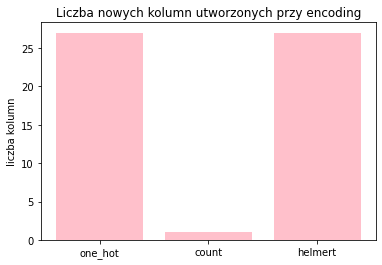

In [9]:
plt.bar(['one_hot', 'count', 'helmert'], [onehot_encoder.shape[1], count_encoder.shape[1], helmert_encoder.shape[1]], color='pink')
plt.title('Liczba nowych kolumn utworzonych przy encoding')
plt.ylabel('liczba kolumn')
plt.show()

Jeśli chodzi o rozmiar powstałych kolumn, metody `one_hot` oraz `helmert` są równie złe, ponieważ zostało utworzonych tyle kolumn, ile było zmiennych kategorycznych, czyli 27. W metodzie `count` dostajemy tylko jedną kolumnę, więc pod tym względem jest najlepsza.

# 2. Uzupełnianie braków
W tej części zadania traktujemy zmienną ***price*** nie jak target, ale zmienną objaśniającą. Zbiór danych ograniczamy do zmiennych numerycznych tj. price, it_seller_rating i it_quantity.

In [10]:
df_numeric = df[['price', 'it_seller_rating', 'it_quantity']]
n = df_numeric.shape[0]

df_numeric.head(2)

,price,it_seller_rating,it_quantity
0,59.99,50177,997
1,4.90,12428,9288


### Usuwanie wartości

Losowo usuwamy 10% wartości ze zmiennej ***it_seller_rating*** i uzupełniamy je z użyciem jednego z automatycznych narzędzi: Nearest neighbors imputation lub Multivariate feature imputation

In [11]:
df_nan = df_numeric.copy(deep=True)

def usun_wartosci(df_nan, nazwa_kolumny):
    rows_numbers = np.random.randint(n,size=n//10)
    df_nan.loc[rows_numbers, nazwa_kolumny] = np.nan
    df_nan

usun_wartosci(df_nan, 'it_seller_rating')
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             150000 non-null  float64
 1   it_seller_rating  135727 non-null  float64
 2   it_quantity       150000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 3.4 MB


### Uzupełnianie braków

In [12]:
# uzupełniamy przy użyciu narzędzia Nearest neighbors imputation o parametrze n_neighbors=3
def uzupelnij_dane(df_nan):
    imputer = KNNImputer(n_neighbors=3, weights='uniform')
    imputed = imputer.fit_transform(df_nan)
    df_imputed = pd.DataFrame(imputed, columns=df_nan.columns)
    return df_imputed

df_imputed = uzupelnij_dane(df_nan)
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             150000 non-null  float64
 1   it_seller_rating  150000 non-null  float64
 2   it_quantity       150000 non-null  float64
dtypes: float64(3)
memory usage: 3.4 MB


### Błąd średniokwadratowy

In [13]:
# liczymy błąd średniokwadratowy (RMSE):
def licz_blad(df_imputed, nazwa_kolumny):
    return rmse(df_numeric[nazwa_kolumny], df_imputed[nazwa_kolumny], squared=False) 
licz_blad(df_imputed, 'it_seller_rating') # bardzo duży błąd

11189.903557361482

### Powtórzenie eksperymentu x10

In [14]:
# w celu powtarzania eksperymentu kilka razy, definiuję funkcję:
def eksperyment_1():
    df_nan = df_numeric.copy(deep=True)

    usun_wartosci(df_nan, 'it_seller_rating')
    df_imputed = uzupelnij_dane(df_nan)
    blad = licz_blad(df_imputed, 'it_seller_rating')
    return blad

bledy = [0]*10
for i in range(10):
    bledy[i] = eksperyment_1()
    
bledy

[10650.420088361981,
 10682.540200685244,
 10677.936606801932,
 10952.533830557844,
 10871.43907394495,
 11291.740748515,
 11104.168801251477,
 10709.462835078697,
 11230.50454973381,
 10722.081672840055]

### Odchylenie standardowe

In [15]:
np.std(bledy)

231.01002472705693

# 2b. Uzupełnianie danych w dwóch kolumnach
Oprócz losowego usuwania 10% wartości z kolumny ***it_seller_rating*** usuniemy także losowo 10% ze zmiennej ***it_quantity***

In [16]:
def eksperyment_2():
    df_nan = df_numeric.copy(deep=True)

    usun_wartosci(df_nan, 'it_seller_rating')
    usun_wartosci(df_nan, 'it_quantity')
    df_imputed = uzupelnij_dane(df_nan)
    
    return [licz_blad(df_imputed, 'it_seller_rating'), licz_blad(df_imputed, 'it_quantity')]

#tworzę 2 wektory do wpisania dziesięciu wartości błędu:
bledy_seller = [0]*10
bledy_quantity = [0]*10

# powtarzam eksperyment 10 razy:
for i in range(10):
    [bledy_seller[i], bledy_quantity[i]] = eksperyment_2()
    
print('it_seller_rating RMSE: ', bledy_seller)
print('it_quantity RMSE: ', bledy_quantity)

it_seller_rating RMSE:  [12682.618824737117, 12262.355583910912, 11924.356024633536, 12288.253092051382, 12429.668977641926, 12058.989970724284, 12215.392461393763, 12350.891965987, 12438.763818549922, 12259.362717196163]
it_quantity RMSE:  [8778.479454036065, 8593.303502137169, 8554.861062845779, 8413.557676889744, 8475.617322495114, 8974.59995106238, 8724.698507877634, 8570.356772943327, 8950.958277479735, 8811.5694743873]


### Odchylenie standardowe

In [17]:
np.std(bledy_seller)

198.448346983219

### Wizualizacja błędów RMSE

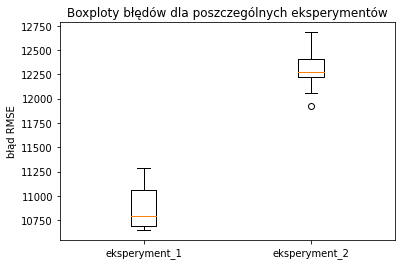

In [18]:
plt.boxplot([bledy, bledy_seller])
plt.xticks([1,2],['eksperyment_1','eksperyment_2'])
plt.title('Boxploty błędów dla poszczególnych eksperymentów')
plt.ylabel('błąd RMSE')
plt.show()

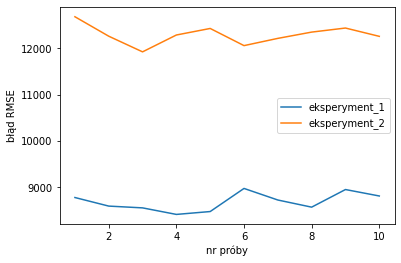

In [19]:
# fig = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,5))
# fig.suptitle('Średnia i odchylenie standardowe błędu RMSE imputacji w 10 próbach')
plt.plot(np.arange(1,11), bledy_quantity)
plt.plot(np.arange(1,11), bledy_seller)
plt.legend(['eksperyment_1', 'eksperyment_2','b'])
plt.xlabel('nr próby')
plt.ylabel('błąd RMSE')
# ax2 = sns.lineplot(ax=axes[0], data = pd.melt(errors_df),x = pd.melt(errors_df)['variable']+1, y = 'value', ci='sd')

plt.show()

Wygląda na to, że w przypadku eksperymentu_2 (czyli z dwoma niepełnymi kolumnami) błąd jest zdecydowanie większy.